In [351]:
import cv2
import glob
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np
import os

In [352]:
#calibration
def calibrate():
    objpoints = []
    imgpoints = []

    chessboard_shape = (9, 6)
    objp = np.zeros((chessboard_shape[0]*chessboard_shape[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:chessboard_shape[0], 0:chessboard_shape[1]].T.reshape(-1, 2)

    for filename in glob.glob('./camera_cal/*.jpg'):    
        img = mpimg.imread(filename)
    
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, chessboard_shape, None)
    
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    return mtx, dist

mtx, dist = calibrate()

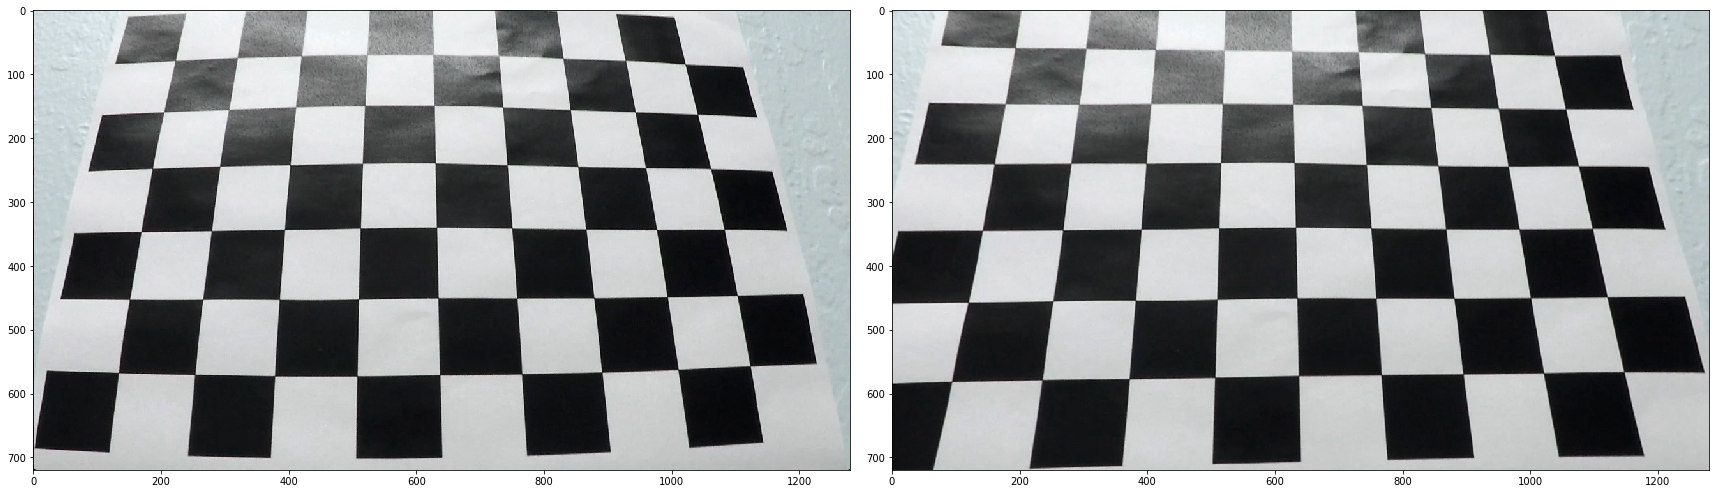

In [353]:
#undistortion
cal_img = cv2.imread('./camera_cal/calibration3.jpg')
dst = cv2.undistort(cal_img, mtx, dist, None, mtx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
fig.tight_layout()
ax1.imshow(cal_img)
ax1.set_title("")
ax2.imshow(dst)
ax2.set_title("")
plt.show()

In [366]:
def color_and_gradient_threshold(img, sobel_x_threshold=(20, 100), hls_s_threshold=(115, 255), 
                                 hls_l_threshold=(195, 255), hsv_v_threshold=(200, 255)):    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sobel_x_threshold[0]) & (scaled_sobel <= sobel_x_threshold[1])] = 1
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= hls_s_threshold[0]) & (s_channel <= hls_s_threshold[1])] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= hls_l_threshold[0]) & (l_channel <= hls_l_threshold[1])] = 1
    
    v_binary = np.zeros_like(s_channel)
    v_binary[(v_channel >= hsv_v_threshold[0]) & (v_channel <= hsv_v_threshold[1])] = 1

    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 0.5) & (l_binary == 0.5)| (v_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

In [367]:
#roi
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    ignore_mask_color = (255,)
    cv2.fillPoly(mask, np.int32([vertices]), ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [368]:
#perspective transform
def perspective_transform(img):
    src = np.float32([[560,460],[180,690],[1130,690],[750,460]])
    dst = np.float32([[320,0],  [320,720],[960,720], [960,0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    transformed_img = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return Minv, transformed_img

In [369]:
def find_lane_pixels(img, nwindows=9, margin=100, minpix=50):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    out_img = np.dstack((img, img, img))
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    window_height = np.int(img.shape[0]//nwindows)

    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ym_per_pixel = 30/720 
    xm_per_pixel = 3.7/700 
    
    left_fit_m = np.polyfit(lefty*ym_per_pixel, leftx*xm_per_pixel, 2)
    right_fit_m = np.polyfit(righty*ym_per_pixel, rightx*xm_per_pixel, 2)
    
    radius, offset = get_radius_and_offset(left_fit_m, right_fit_m, ym_per_pixel, xm_per_pixel)

    lane_pixel_img = np.dstack((img, img, img))*255
    lane_pixel_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    lane_pixel_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return leftx, lefty, rightx, righty, radius, offset, out_img

In [370]:
def draw_polynomial(img, fit):
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    x = fit[0]*y**2 + fit[1]*y + fit[2]
    pts = np.array([np.transpose(np.vstack([x, y]))])
    cv2.polylines(img, np.int_(pts), isClosed=False, color=(255, 255,0), thickness=5)

In [371]:
def fit_polynomial(img):
    leftx, lefty, rightx, righty, radius, offset, out_img = find_lane_pixels(img)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    draw_polynomial(out_img, left_fit)
    draw_polynomial(out_img, right_fit)
    
    return ploty, left_fit, right_fit, radius, offset, out_img

In [372]:
def unwarp(original_img, img, left_fit, right_fit, Minv):
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    plot_y = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_x = left_fit[0]*plot_y**2 + left_fit[1]*plot_y + left_fit[2]
    right_x = right_fit[0]*plot_y**2 + right_fit[1]*plot_y + right_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_x, plot_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x, plot_y])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    warp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    result = cv2.addWeighted(original_img, 1, warp, 0.3, 0)
    return result

In [373]:
def get_radius_and_offset(left_fit, right_fit, ym_per_pixel, xm_per_pixel):
    left_curverad =  ((1 + (2*left_fit[0]*720*ym_per_pixel + left_fit[1])**2)**(3/2))/np.abs(2*left_fit[0])
    right_curverad =  ((1 + (2*right_fit[0]*720*ym_per_pixel + right_fit[1])**2)**(3/2))/np.abs(2*right_fit[0])
    
    left_lane = left_fit[0]*(720*ym_per_pixel)**2 + left_fit[1]*720*ym_per_pixel + left_fit[2]
    right_lane = right_fit[0]*(720*ym_per_pixel)**2 + right_fit[1]*720*ym_per_pixel + right_fit[2]
    
    radius = np.mean([left_curverad, right_curverad])
    offset = [640*xm_per_pixel - np.mean([left_lane, right_lane]), right_lane-left_lane]
    return radius, offset

In [374]:
def display_radius_and_curvature(result_img, radius, offset):   
    cv2.putText(result_img, 'Radius: {} m'.format(round(radius)), (50, 100), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 4)
    cv2.putText(result_img, 'Offset: {} m'.format(round(offset[0], 3)), (50, 200), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 4)   
    return result_img

In [375]:
def image_pipeline(img, plot=0):
    distorted = cv2.undistort(img, mtx, dist, None, mtx)
    blurred = cv2.GaussianBlur(distorted, (5,5), 0)
    thresholded = np.zeros_like(blurred)
    thresholded = color_and_gradient_threshold(blurred)
    vertices = np.array([[130, 720], [625, 430], [700, 430], [1200, 720]])
    roi = region_of_interest(thresholded, [vertices])
    Minv, warped = perspective_transform(roi)
    ploty, left_fit, right_fit, radius, offset, polyfit_img = fit_polynomial(warped)
    projected = unwarp(img, warped, left_fit, right_fit, Minv)
    out = display_radius_and_curvature(projected, radius, offset)
    
    if (plot == 1):
        f, axs = plt.subplots(4, 2, figsize=(40, 40))
        f.tight_layout()
        axs[0, 0].imshow(img)
        axs[0, 0].set_title('raw', fontsize=8)        
        axs[0, 1].imshow(blurred)
        axs[0, 1].set_title('blurred', fontsize=8)
        axs[1, 0].imshow(distorted)
        axs[1, 0].set_title('undistorted', fontsize=8)
        axs[1, 1].imshow(thresholded)
        axs[1, 1].set_title('thresholded', fontsize=8)
        axs[2, 0].imshow(roi)
        axs[2, 0].set_title('roi', fontsize=8)
        axs[2, 1].imshow(warped)
        axs[2, 1].set_title('warped', fontsize=8)
        axs[3, 0].imshow(polyfit_img)
        axs[3, 0].set_title('fitted', fontsize=8)
        axs[3, 1].imshow(out)
        axs[3, 1].set_title('output', fontsize=8)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
        plt.savefig('./output_images/pipeline.png')

    return out 

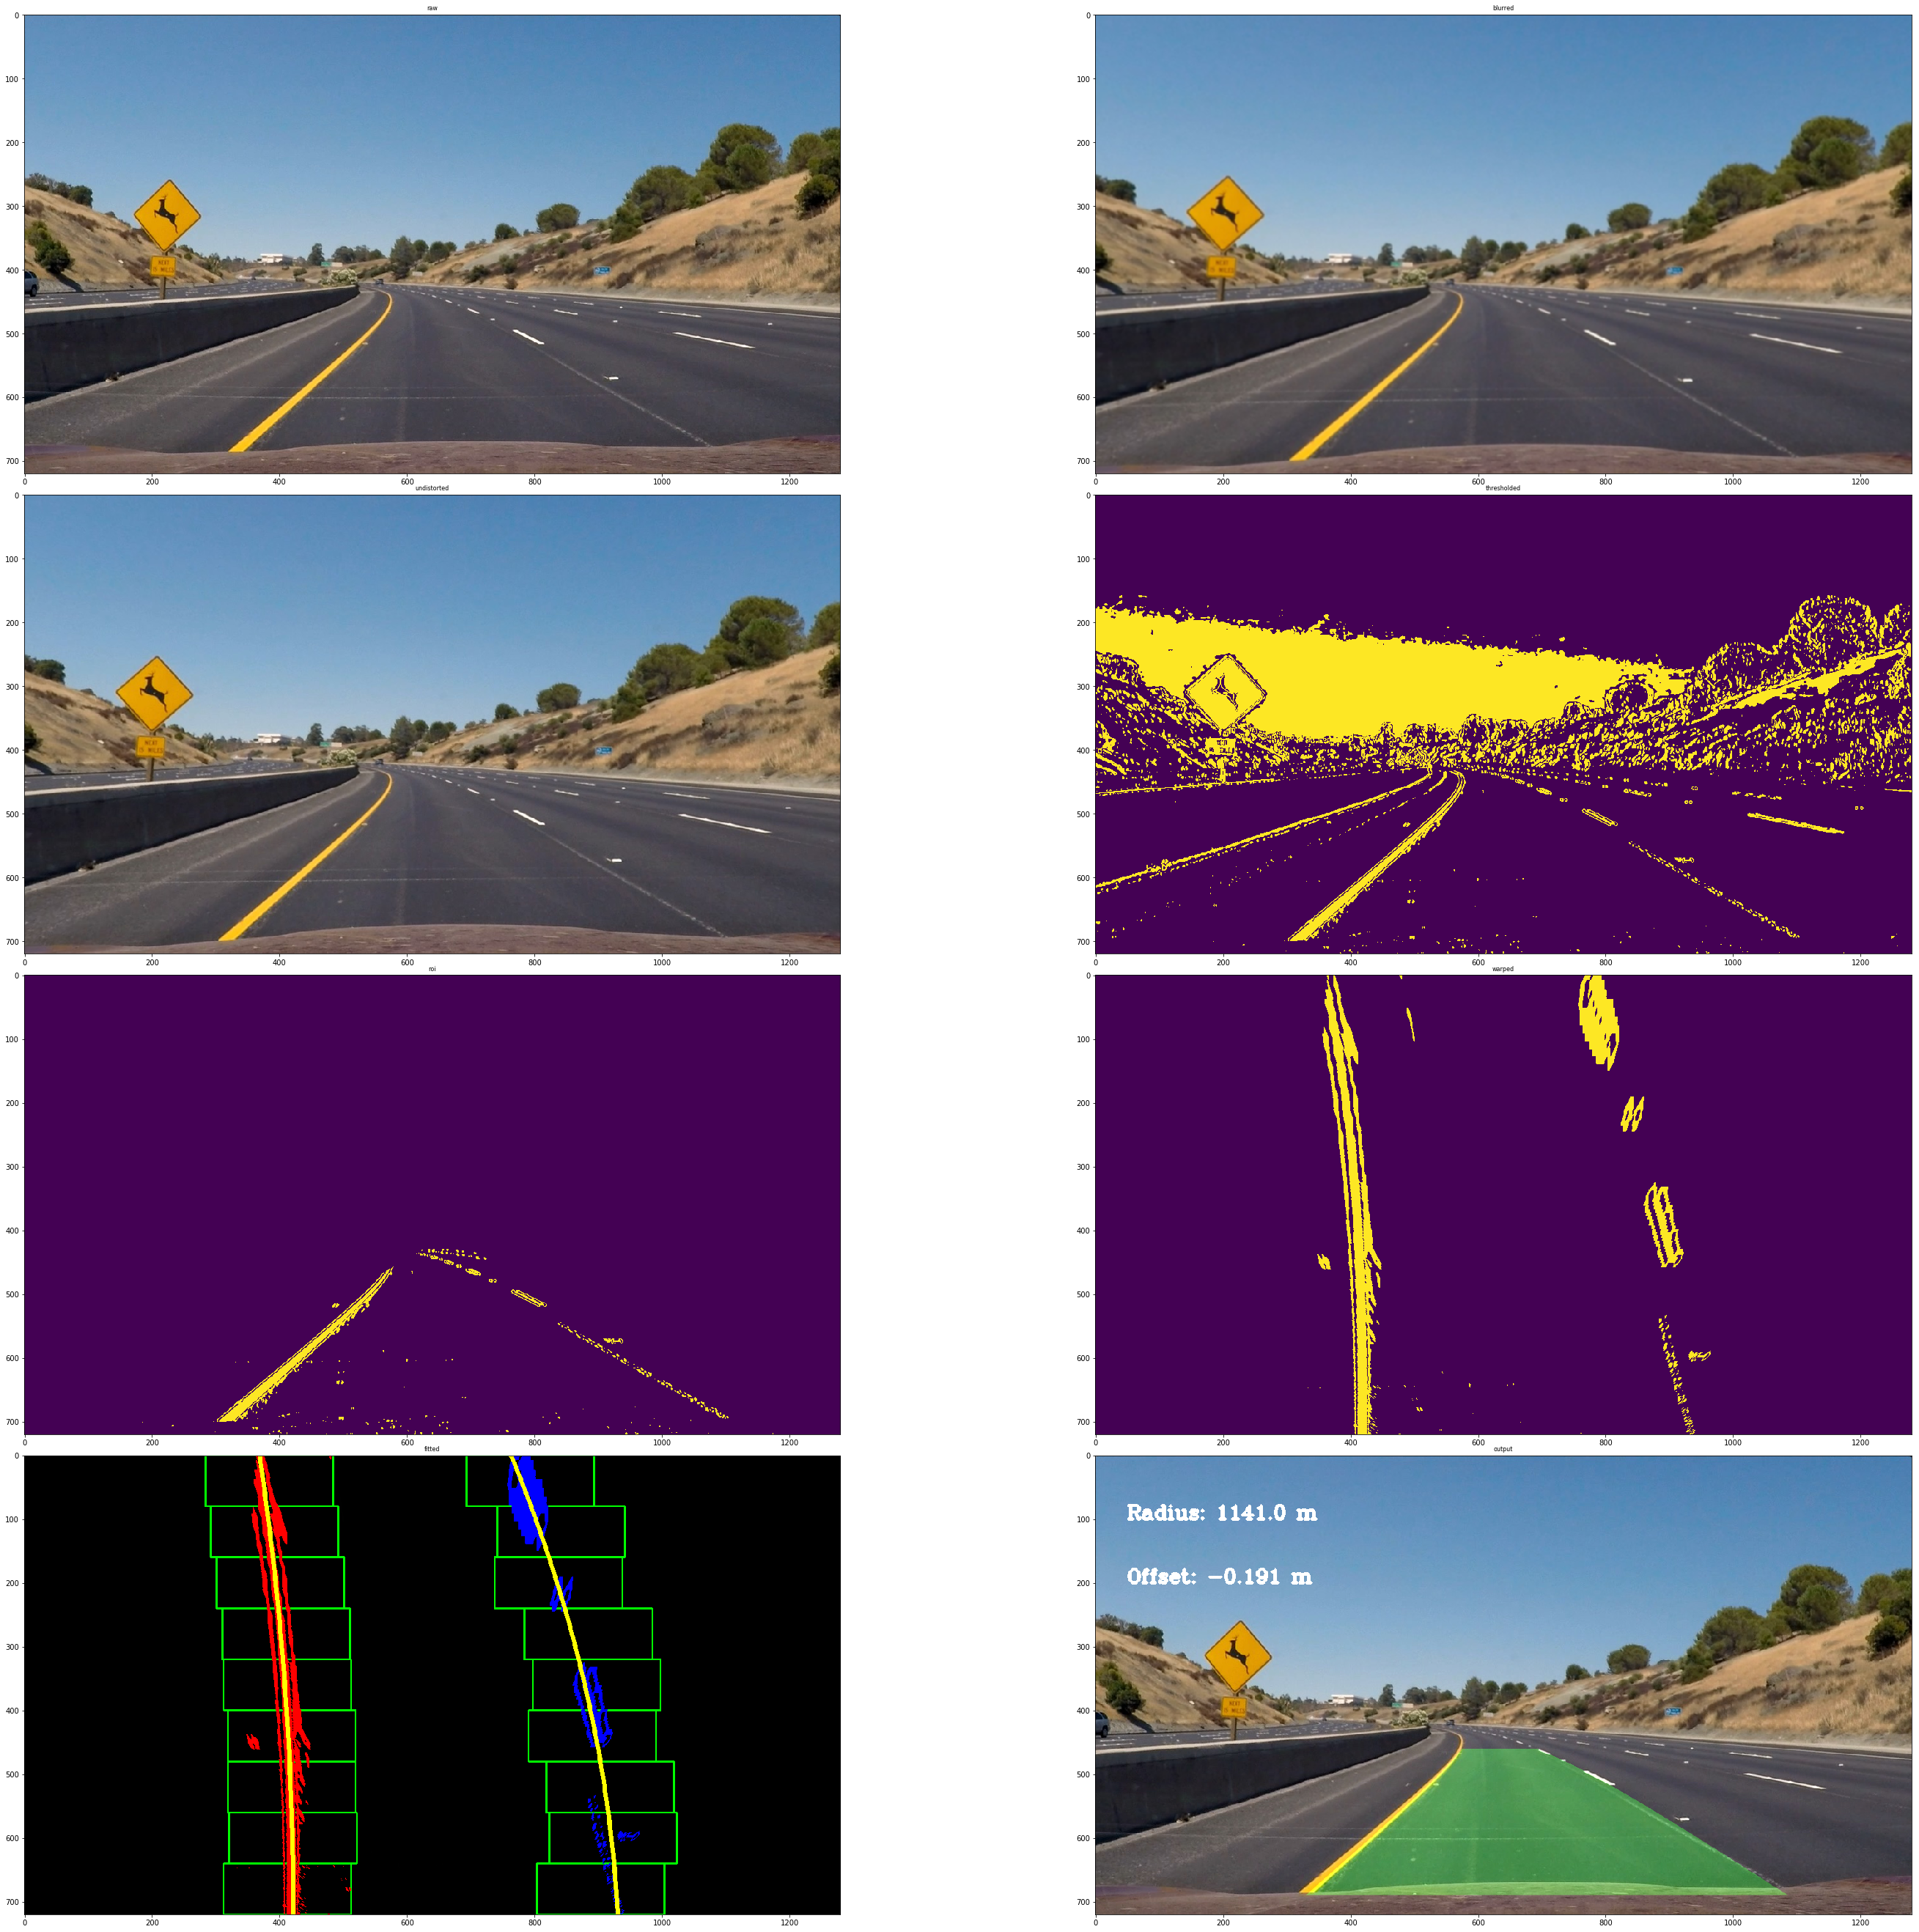

array([[[251, 240, 236],
        [217, 209, 207],
        [184, 182, 187],
        ..., 
        [ 26,  36,  46],
        [ 39,  43,  52],
        [ 46,  46,  54]],

       [[196, 199, 206],
        [146, 153, 163],
        [130, 142, 156],
        ..., 
        [ 47,  65,  87],
        [ 20,  33,  52],
        [ 32,  40,  59]],

       [[134, 155, 176],
        [132, 156, 180],
        [106, 136, 164],
        ..., 
        [ 86, 118, 156],
        [ 52,  78, 113],
        [ 12,  35,  69]],

       ..., 
       [[128, 113, 106],
        [ 94,  80,  71],
        [ 94,  80,  71],
        ..., 
        [ 88,  71,  64],
        [ 91,  74,  67],
        [132, 115, 108]],

       [[132, 119, 111],
        [101,  88,  80],
        [ 93,  79,  70],
        ..., 
        [ 89,  74,  69],
        [104,  89,  84],
        [135, 120, 115]],

       [[145, 132, 124],
        [126, 113, 105],
        [103,  89,  80],
        ..., 
        [ 73,  58,  53],
        [122, 107, 102],
        [147, 132,

In [378]:
#image in pipeline
img = mpimg.imread('test_images/test2.jpg')
image_pipeline(img, 1)

In [377]:
#video in pipeline
video_out = './output_video/lane_detection_video.mp4'
video_clip = VideoFileClip("project_video.mp4")
clip = video_clip.fl_image(image_pipeline)
clip.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video ./output_video/lane_detection_video.mp4
[MoviePy] Writing video ./output_video/lane_detection_video.mp4


100%|█████████▉| 1260/1261 [01:24<00:00, 16.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/lane_detection_video.mp4 



In [348]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_out))